# Transfer Learning using EfficientNetB0

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

2022-04-11 12:47:12.108329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 12:47:12.108347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1520


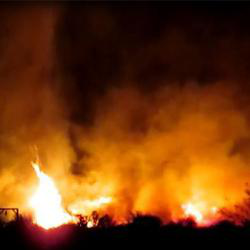

In [4]:
fire = list(data_dir.glob('fire/*'))
img = PIL.Image.open(str(fire[0]))
display(img)

### Load data into a tf dataset

Image input sizes: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [5]:
batch_size = 32
img_height = 224
img_width = 224

# Validation split 80/20

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 1520 files belonging to 2 classes.
Using 1216 files for training.


2022-04-11 12:47:32.241745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 12:47:32.241924: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-11 12:47:32.242175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-11 12:47:32.242216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-11 12:47:32.242251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size    
    )


Found 1520 files belonging to 2 classes.
Using 304 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

Found 381 files belonging to 2 classes.


### Get Class Names

In [8]:
class_names = train_ds.class_names
print(class_names)

['fire', 'nofire']


### Visualise Data

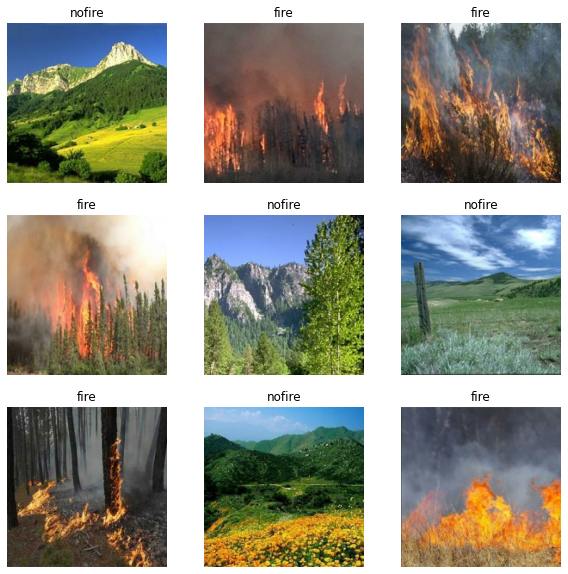

In [9]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Configure the dataset for performance

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

### Create the base model from pre-trained convnets

In [24]:
## By specifying "include_top=False" argument you load a network that doesn't 
## include the classification layers at the top, which is ideal for feature extraction

IMG_SHAPE = (img_width, img_height) + (3,)

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    classifier_activation="softmax",
)


image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 1280)


## Feature Extraction

In [25]:
base_model.trainable = False
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation) 

 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
          

                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
          

 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization) 

                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_d

## Add classification head

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [27]:
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


### Chain together the model

In [28]:
inputs = tf.keras.Input(shape = (IMG_SHAPE))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [29]:
# Useful metrics paper:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=(True)),
              metrics = [tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall"),tf.keras.metrics.AUC(name = "auc")] )

In [30]:

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_____________________________________________

## Train the model

In [31]:
# Tests the initial base model
initial_epochs = 10
loss0, precision0, recall0, auc0 = model.evaluate(val_ds)

10/10 [==============================] - 7s 597ms/step - loss: 0.7080 - precision: 0.5092 - recall: 0.5570 - auc: 0.4978


In [32]:
print("initial loss: {:.2f}".format(loss0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))
print("initial auc: {:.2f}".format(auc0))

initial loss: 0.71
initial precision: 0.51
initial recall: 0.56
initial auc: 0.50


In [33]:
history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = val_ds)

Epoch 1/10
38/38 [==============================] - 35s 811ms/step - loss: 0.6804 - precision: 0.5691 - recall: 0.5254 - auc: 0.5931 - val_loss: 0.6154 - val_precision: 0.7292 - val_recall: 0.7047 - val_auc: 0.7938
Epoch 2/10
38/38 [==============================] - 31s 810ms/step - loss: 0.5962 - precision: 0.7477 - recall: 0.6547 - auc: 0.7965 - val_loss: 0.5409 - val_precision: 0.8681 - val_recall: 0.8389 - val_auc: 0.9304
Epoch 3/10
38/38 [==============================] - 31s 822ms/step - loss: 0.5199 - precision: 0.8810 - recall: 0.7872 - auc: 0.9193 - val_loss: 0.4789 - val_precision: 0.9220 - val_recall: 0.8725 - val_auc: 0.9722
Epoch 4/10
38/38 [==============================] - 31s 817ms/step - loss: 0.4705 - precision: 0.9149 - recall: 0.8445 - auc: 0.9547 - val_loss: 0.4268 - val_precision: 0.9444 - val_recall: 0.9128 - val_auc: 0.9867
Epoch 5/10
38/38 [==============================] - 31s 828ms/step - loss: 0.4215 - precision: 0.9376 - recall: 0.8854 - auc: 0.9746 - val_l

### Learning Curves

Found 381 files belonging to 2 classes.


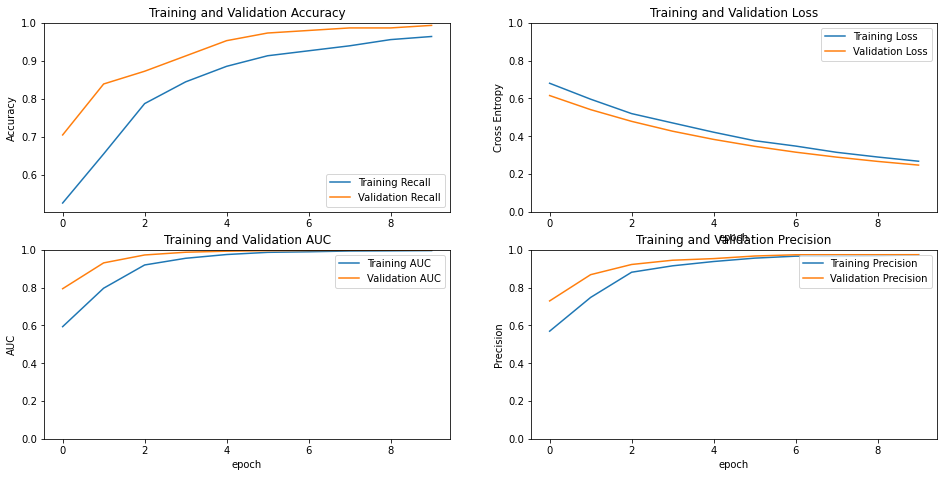

In [34]:
recall = history.history['recall']
val_recall = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

precision = history.history['precision']
val_pre = history.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0,1.0])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()




## Fine Tuning

In [35]:
# Previously the base model weights were not updated and only a few layers on top of the EfficientNetV2 was trained
# Unfreeze and train the top layers of the pre-trained model to fine tune to the dataset

## Un-freeze top layers of the model

base_model.trainable = True

In [36]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  237


In [37]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the Model

In [38]:
## Important to use a lower training weight since using more layers, otherwise
# it could overfit very quickly 

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = [tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall"),tf.keras.metrics.AUC(name = "auc")])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 3,841,629
Non-trainable params: 209,223
___________________________________________

In [39]:
print(len(model.trainable_variables))


125


### Continue Training the Model

In [40]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds)


Epoch 10/20
38/38 [==============================] - 60s 1s/step - loss: 0.1486 - precision: 0.9901 - recall: 0.9820 - auc: 0.9988 - val_loss: 0.0877 - val_precision: 0.9868 - val_recall: 1.0000 - val_auc: 0.9992
Epoch 11/20
38/38 [==============================] - 52s 1s/step - loss: 0.0624 - precision: 0.9902 - recall: 0.9902 - auc: 0.9997 - val_loss: 0.0439 - val_precision: 0.9933 - val_recall: 1.0000 - val_auc: 0.9993
Epoch 12/20
38/38 [==============================] - 52s 1s/step - loss: 0.0306 - precision: 0.9918 - recall: 0.9951 - auc: 0.9999 - val_loss: 0.0295 - val_precision: 0.9933 - val_recall: 1.0000 - val_auc: 0.9993
Epoch 13/20
38/38 [==============================] - 60s 2s/step - loss: 0.0161 - precision: 0.9967 - recall: 0.9984 - auc: 1.0000 - val_loss: 0.0245 - val_precision: 0.9868 - val_recall: 1.0000 - val_auc: 0.9994
Epoch 14/20
38/38 [==============================] - 54s 1s/step - loss: 0.0078 - precision: 0.9984 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.018

### Learning Curves

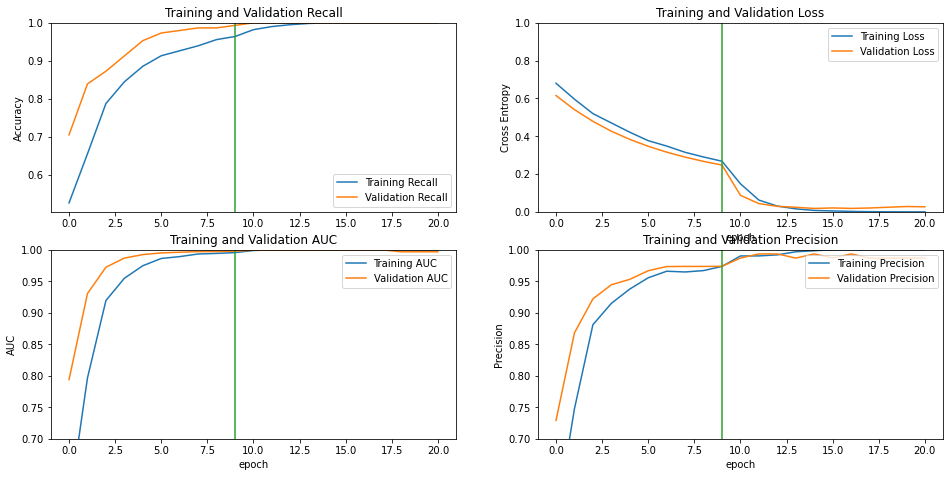

In [41]:
recall += history_fine.history['recall']
val_recall += history_fine.history['val_recall']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

precision += history_fine.history['precision']
val_pre += history_fine.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Recall')

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()




In [42]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
    )


test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

Found 381 files belonging to 2 classes.


## Testing on test set

In [43]:
loss, precision, recall, auc = model.evaluate(test_ds)
print('Test loss :', loss)
print('Test precision :', precision)
print('Test recall :', recall)
print('Test auc :', auc)

12/12 [==============================] - 8s 657ms/step - loss: 0.0282 - precision: 0.9894 - recall: 0.9791 - auc: 0.9996
Test loss : 0.02818896248936653
Test precision : 0.9894179701805115
Test recall : 0.9790576100349426
Test auc : 0.9996417760848999


In [45]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()


In [46]:
print(np.round(predictions, 3))

[1.    0.    1.    0.001 1.    0.    0.    1.    1.    1.    1.    0.
 1.    0.    0.    0.001 1.    0.008 0.    0.    0.    1.    0.    1.
 1.    0.    1.    1.    0.001 1.    0.    0.002]


In [47]:
predictions = tf.where(predictions < 0.5, 0, 1)
print(predictions)

tf.Tensor([1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0], shape=(32,), dtype=int32)


Predictions:
 [0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0]
Labels:
 [0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0]


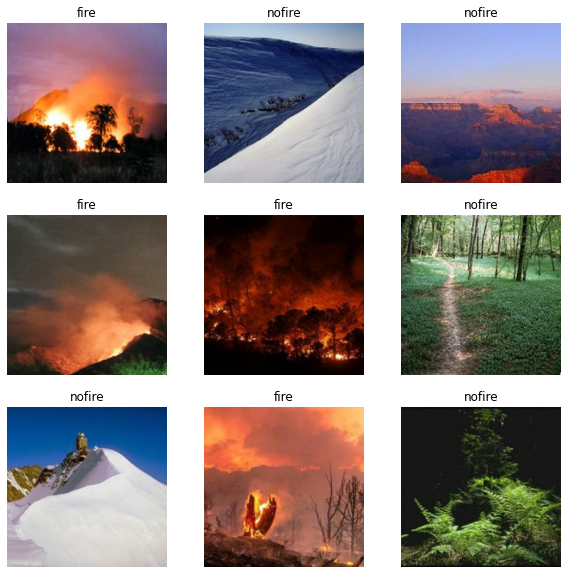

In [48]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# LOOK AT EXTRACTING THE MISSCLASSIFIED IMAGES AND TALK ABOUT WHY THEY HAVE BEEN MISSCLASSIFIED (SIMILAR FEATURES, LOOKS LIKE A SUNSET ETC)

### Confusion Matrix

In [49]:
import pandas as pd
con_mat = tf.math.confusion_matrix(labels = label_batch, predictions=predictions).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)

#con_mat_df = pd.DataFrame(con_mat_norm,
con_mat_df = pd.DataFrame(con_mat,
                          index = class_names,
                          columns = class_names)


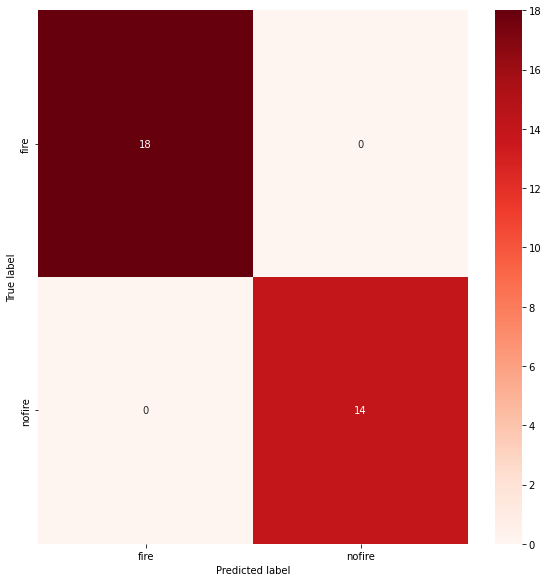

In [50]:
import seaborn as sns
figure = plt.figure(figsize = (8, 8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [51]:
model.save('model00_EfficientNetB0.h5')

In [10]:
import tensorflow as tf
import pathlib
import numpy as np
data_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')


loaded_model = tf.keras.models.load_model('model00_EfficientNetB0.h5')

In [19]:
from tensorflow.keras.preprocessing import image
f = f'{test_dir}/fire/abc002.jpg'
print(f, type(f))
test_image = image.load_img(f'{test_dir}/fire/abc185.jpg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = loaded_model.predict(test_image)

print(result)


/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing/fire/abc002.jpg <class 'str'>
[[0.00019914]]


In [20]:

if result[0]>0.5:
    print("The image classified as no fire")
else:
    print("The image classified as fire")

The image classified as fire


## Testing on custom images

In [21]:
from tensorflow.keras.preprocessing import image
import os

def test_images(img_directory, input_shape):
    preds = []
    false_images = []
    for file in os.listdir(img_directory):
        f = os.path.join(img_directory, file)
        test_image_og = image.load_img(f,
                                    target_size = input_shape)
        test_image = image.img_to_array(test_image_og)
        test_image = np.expand_dims(test_image, axis = 0)
        result = loaded_model.predict(test_image)
        preds.append(result[0][0])
        if result[0][0] < 0.5:
            false_images.append(test_image_og)
    plt.figure(figsize=(20, 20))
    for count, i in enumerate(false_images):
        x = len(false_images)
        ax = plt.subplot(x, x, count + 1)
        plt.imshow(i)
        plt.axis("off")
    return preds

input_shape = (224, 224)
img_directory = '/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Photos-001/'

test_preds = test_images(img_directory, input_shape)



NameError: name 'plt' is not defined

In [ ]:
count = 0
for i in test_preds:
    if i>0.5:
        print("no fire")
    else:
        count += 1
        print("fire")
print('Incorrectly predicted ', count,  ' out of ',len(test_preds), '. FPR: ', round(count/len(test_preds), 2))

# Feature extraction